# Topographic Factor Analysis 

This notebook is an implementation of Topographic Factor Analysis: A Bayesian Model for
Inferring Brain Networks from Neural Data ( Jeremy R. Manning, Rajesh Ranganath, Kenneth A. Norman, David M. Blei) using Autoencoders. The paper applies Stochastic Variatonal Inference to a Spatial factor analysis model; particularly in understanding contribution of different spatial areas of the brain to a particular activity, based on fMRI scans

"""
Antonio Moretti - August 2017

Test stochastic variational inference for a simple spatial factor analysis
model on a (d = 2) dimensional lattice. Algorithm is described in the paper:
    
    Topographic Factor Analysis by Manning and Ranganath
    https://www.cs.princeton.edu/~rajeshr/papers/MannEtal13b.pdf
    
although this is used as illustration - the technique can be used to fit novel
spatial statistics models.

In order to compute the cost, we must:
    
    (1) Define how to draw a sample from the variational approximation (recognition model).
    
            q ~ q(w,m,l|alpha)
            
    (2) Compute the log of the variational distribution. We avoid analytically evaluating
        the entropy by using a technique detailed in Black Box Variational Inverence by Ranganath.
        This lets us express our cost gradient by evaluating the scores [ differentiating only ln q() ].
        
            ln q(w,m,l|alpha) = ln q(w) + ln q(m) + ln q(l)
            
        In both VI methods described in Black Box Variational Inference and the Stochastic
        Gradient Variational Bayes method, we need to compute the log of the recognition model.

    (3) Using the sample q ~ q(w,m,l|alpha), define how to evaluate the log 
        probability of the prior (the generative model). Given a sample from the set 
        S = {X, Y}, we compute P(Y,X) = P(Y|X)P(X) which is defined more formally:
        
            ln p(y, w, m, l) = ln p(y|q,m,l) + ln p(w) + ln p(m) + ln p(l)
        
        Note that we must be clever here in how we evaluate ln p(y) which requires
        the specification of the source image matrix F.
        
            ln p(y|w,m,l) = N(y | W * F, sigma^2)
            
    (4) TODO: support several kernels that can be used to build F from spatial functions. We
        define a subroutine to compute the source image matrix from M and L (sampled from q)
        using RBFs, which can easily extend to ellipsoids and Matern covariance functions.
        These can be defined isotropic or with correlations although this affects sampling q
        and the cost.
        
        WARNING:
        ** poor hyperparameters can cause F to take values too large, or result in numerical issues... 
        
        TODO: define the Matern kernel in R^n using Bessel function Jn
        
    (5) Compute the scores [ the gradient of each term in ln q(W,M,L) wrt recognition hyperparameters].
        Note that the gradient of the sum of univariate log Gaussians is the sum of the gradient of ln Normal.
        
    (6) We can now define the cost ( TheCost = E[ln P(Y,W,M,L)] + H[Q] ) and it's gradient:
            
            \Nabla theCost = theScores * (lnLikelihood - lnQ)
                           = [ \Nabla ln q(w,m,l|alpha) ] * [ ln p(y,w,m,l) - ln q(w,m,l|alpha) ]
        
"""

In [13]:
# Importing packages

import numpy as np
import scipy as sp
from scipy.stats import norm
%matplotlib inline

Setting the parameters first: these include basic variables like Number of sources of the Spatial Model, dimensions, etc.

In [14]:
# define some basic parameters
K = 5                       # number of sources
D = 2                       # dimension of space in which lattice lives
N = 10                      # number of scans
lattice_shape = 50          # dimension of lattice
V = lattice_shape**D        # define lattice_shape x lattice_shape in R^D

c = 25          # center of brain image, computed from dataset
var_mu = 5000     # contains the variances across voxel coordinates along each dimension

Setting different hyperparameter values for the generative model to a dictionary. Generative model represented by theta.

In [15]:
# define dictionary of hyperparameters for generative model (theta)
pi = {
      'sigma_sq_y' : 0.1,                    # voxel noise parameter
      'mu_w'       : 0.0,                    # mean of source weight distribution
      'k_w'        : np.log(0.5),            # log precision of source weight distribution
      'c'          : c,                      # mean of distribution over source centers
      'k_mu'       : np.log(1./(10*var_mu)), # diagonal of log precision of source center distribution
      'mu_lambda'  : 50.0, # 1.0  50?        # mean of distribution over source widths
      'k_lambda'   : np.log(1./3.)           # log precision of distribution over source widths
     }

Setting different hyperparameter values for the recognition model to a dictionary. Recognition model represented by phi. Variable name used alpha

In [16]:
# define dictionary of hyperparameters for recognition model (phi)
# note that the means here (_mu_w_nk, _mu_mu_k, and _mu_lambda_k - the mean of distribution over weights
# centers and widths can be randomly initialized or chosen through hotspot initialization described in 1.4.1)
# they are randomly initialized / arbitrariliy set to 2.0 here.
alpha = {
        '_mu_w_nk'      : 1.0,                  # mean of distribution over source k's weight in image n 
        '_k_w_nk'       : np.log(10),           # log precision of distribution over source k's weight in image n
        '_mu_mu_k'      : 25.0,                 # mean of distribution over source k's center
        '_k_mu_k'       : np.log(100./var_mu),  # diagional of log precision of distribution over source k's center
        '_mu_lambda_k'  : 50.,                  # mean of distribution over source k's width
        '_k_lambda_k'   : 0.5                   # log precision of distribution over source k's width
        }

Method for sampling from the recognition model - since the distribution **q(W,M, $lambda$ | $alpha$)** fully factorizes, each variable is drawn independently. So for every source, we pick a source center, a source width and a source weight from a Normal distribution

In [17]:
def getSample(alpha, K, D, N):
    """
    Draws one sample from the variational approximation (aka the recognition model) q ~ q(w,m,lambda|alpha).
    Yields one value for each of the hidden variables, including per-image source weights, source centers
    and source widths. Each variable is drawn independently b/c q(w,m,lambda) fully factorizes.
    --------------------------------------------------------------------------------------------------------
    Input: 
            * alpha : dictionary of hyperparameters
            * K     : number of sources
            * D     : dimension of space in which the lattice lives
            * N     : number of scans
    
    Output:
            * M     : source centers (on the lattice) for each of the k sources
            * W     : weights for the k sources in the n scans (factor loading matrix)
            * L     : source widths for each of the k sources
    """
    M = np.zeros([K,D])
    L = np.zeros(K)
    W = np.zeros([N,K])
    
    for k in range(K):
    
        # Sample source center m ~ q(m)
        M[k,:] = np.random.multivariate_normal(np.ones(D)* alpha['_mu_mu_k'], np.eye(D)*np.exp((1./alpha['_k_mu_k'])))
        
        # Sample source width  l ~ q(l)
        L[k]   = np.random.normal(alpha['_mu_lambda_k'], np.exp(1.0/alpha['_k_lambda_k'])) ## <- should not be negative!
        
        # Sample weights       w ~ q(w)
        W[:,k] = np.random.multivariate_normal(np.ones(N)*alpha['_mu_w_nk'], np.eye(N)*np.exp(1.0/alpha['_k_w_nk']))
        
    q = M, L, W
    
    return q

# Algorithm to Compute cost

## 1. Sampling from the recognition model
We first sample from the variation approximation (recognition model)

In [18]:
# draw a sample from the approximate posterior
q = getSample(alpha, K, D, N)

## 2. Computing log of the variational distribution
Next we compute the log of the variational distribution using the technique detailed in Black Box Variational Inverence by Ranganath. **make_mvn_pdf** and **compute_lnQ** are methods that define a Multivariate Gaussian Density and compute the log of the variational distribution using these densities respectively

In [19]:
def make_mvn_pdf(mu, sigma):
    """
    Defines a multivariate Gaussian density. This is useful when computing ln p(y,w,m,l) and ln q(w,m,l).
    """
    def f(x):
        return sp.stats.multivariate_normal.pdf(x, mu, sigma)
    
    return f


def compute_lnQ(alpha, q, K, D, N):
    """
    Computes the log of the variational distribution given by the following.
        ln q(W,M,L|alpha) = ln q(weights) + ln q(centers) + ln q(widths)
    """
    # Unpack values of our hidden variables sampled from q ~ q(w,m,lambda)
    M, L, W = q[0], q[1], q[2]
    # Define seperate terms for each of the log probabilities above.
    T1 = T2 = T3 = 0

    # T1 = \prod_n \prod_k ln q(w)
    q_w = make_mvn_pdf(np.ones(N)*alpha['_mu_w_nk'], np.eye(N)*np.exp(1.0/alpha['_k_w_nk']))
    # T2 = ln \prod_k \prod_d q(m)
    q_m = make_mvn_pdf(np.ones(D)* alpha['_mu_mu_k'], np.eye(D)*np.exp((1./alpha['_k_mu_k'])))
    # T3 = ln \prod_k q(l)
    q_l = make_mvn_pdf(alpha['_mu_lambda_k'], np.exp(1.0/alpha['_k_lambda_k'])) ## <- should not be negative!
    
    # TODO : can define this summation a bit more efficiently...
    # If independent, joint is product of marginals p(M) = p(m1)p(m2)p(m_n)
    for m in M:
        
        T2 += np.log(q_m(m))
    
    for w in W.T:
        
        T1 += np.log(q_w(w))
    
    for l in L:
        
        T3 += np.log(q_l(l))
        
    
    Lik = T1 + T2 + T3
    
    return Lik   

Evaluating log of variational distribution and storing it in **prob_q**

In [20]:
# evaluate lnQ
prob_q = compute_lnQ(alpha, q, K, D, N)

## 3. Computing log p(Y, W, M, Λ)
Next, we compute the log probability of the prior (the generative model) using sample q.

**ln p(y, w, m, l) = ln p(y|q,m,l) + ln p(w) + ln p(m) + ln p(l)**

This consists of a few steps. First we compute a source image matrix using a sample from the recognition model

In [21]:
def sourceImageMatrix(q,V, lattice_shape, kernel='RBF'):
    """
    Computes the source image matrix using a sample from the recognition model
    --------------------------------------------------------------------------
    Input:
            * q : q ~ q(w,m,lambda) sample from the recognition model
            * V : the number of voxels (lattice points flattened to a vector)
    Output:
            * F : [K x V] source image matrix constructed from mu, lambda
            **            the kernel to use    (rbf, exponential, matern)
    """
    # Grab centers and widths from our sample q (works regardless of shape)
    M, L = q[0], q[1]
    # Define the number of sources and the dimension of space lattice lives in
    K, D = q[0].shape
    # Initialize the source image matrix keeping lattice flattened to vector
    F = np.zeros([K,V])
    
    # Build components of source image matrix (big matrix likely inefficient...)
    # TODO: smarter way of computing F...
    for k in range(K):
        for v in range(V):
            
            # Here we call an external spatial function (TODO: pass this in...)
            loc = np.array(divmod(v,lattice_shape)) - 1 # array index starts at 0
            if kernel == 'RBF':
                F[k,v] = np.exp(- (1./L[k]) * np.dot((M[k] - loc),(M[k] - loc)))
            if kernel == 'exponential':
                F[k,v] = np.exp(- (1./L[k]) * np.sqrt(np.dot((M[k] - loc),(M[k] - loc))))
            
    return F
    
myF = sourceImageMatrix(q,V,lattice_shape, kernel = 'RBF')

At this point, the source Image matrix as estimated from the recognition model is ready. We can see how it looks like:


inspecting the source image matrix:



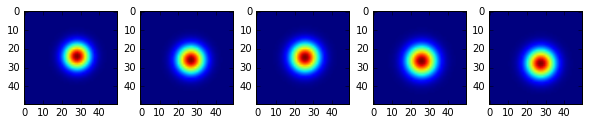

In [22]:
# quickly inspect source image matrix F
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()

print "\ninspecting the source image matrix:\n"

fig,axs = plt.subplots(1,K, figsize = (10,10))
fig.subplots_adjust(hspace = 1.5, wspace=.25)
for k in range(K):
    axs[k].imshow(myF[k,:].reshape(lattice_shape, lattice_shape))
    
plt.show()

Next we define the method that calculates the log probability of the Generative model using the formula mentioned above

In [23]:
def evaluate_logDensity(Y, phi, q, K, D, N,V,lattice_shape):
    """
    Computes the log probability of the Generative Model evaluated at a sample
    drawn from the Recognition Model. Given a sample from the set 
    S = {X, Y}, we compute P(Y,X) = P(Y|X)P(X) which is defined more formally:
        
        ln p(y, w, m, l | alpha) = ln p(y) + ln p(w) + ln p(m) + ln p(l)
    
    Note that one must be clever about how to compute the source image matrix.
    On a 3 dimensional lattice we wish to avoid evaluation quartic in the input size.
    ---------------------------------------------------------------------------
    Input:
            * phi           : dictionary of recognition model hyperparameters
            * K             : number of sources
            * D             : dimension of space in which the lattice lives
            * N             : number of scans
            
    Output:
            * ln p(y,w,m,l) : numerical value for the log probability of the
                              generative model using hidden variables sampled
                              from the recognition model q.
    """
    # Unpack values of our hidden variables sampled from q ~ q(w,m,lambda)
    M, L, W = q[0], q[1], q[2]
    
    T0 = T1 = T2 = T3 = 0
    
    # -------------------------------------------------------------------------
    # compute ln p(y) = N(y | W * F, sigma^2) and evaluate source image matrix
    F       = sourceImageMatrix(q,V,lattice_shape)
    y_bar   = np.dot(W,F) 

    # T1 = \prod_n \prod_k ln q(w)
    q_w = make_mvn_pdf(np.ones(N)*phi['mu_w'], np.eye(N)*np.exp(1.0/phi['k_w']))
    # T2 = ln \prod_k \prod_d q(m)
    q_m = make_mvn_pdf(np.ones(D)* phi['c'], np.eye(D)*np.exp((1./phi['k_mu'])))
    # T3 = ln \prod_k q(l)
    q_l = make_mvn_pdf(phi['mu_lambda'], np.exp(1.0/phi['k_lambda']))
    
    import pdb
    # T0 = \prod_n \prod_v ln p(y|w,m,lambda)
    '''
    for n in range(N):
        import pdb
        pdb.set_trace()
        q_y = make_mvn_pdf(y_bar[n,:], phi['sigma_sq_y']*np.eye(lattice_shape*lattice_shape))
        T0 += np.log(q_y(Y[n,:]))
    '''
    for n in range(N):
        for v in range(V):
            #pdb.set_trace()
            q_y = make_mvn_pdf(y_bar[n,v],phi['sigma_sq_y'])
            T0 += np.log(q_y(Y[n,v]))
    
    # TODO : can define this summation a bit more efficiently...
    # If independent, joint is product of marginals p(M) = p(m1)p(m2)p(m_n)
    for m in M:
        
        T2 += np.log(q_m(m))
    
    for w in W.T:
        
        T1 += np.log(q_w(w))
    
    for l in L:
        #pdb.set_trace()
        T3 += np.log(q_l(l))
        
    
    return [T0 + T1 + T2 + T3, T0, T1, T2, T3]

In [24]:
y_bar = np.dot(q[2],myF)


weighted source image matrices for each scan:



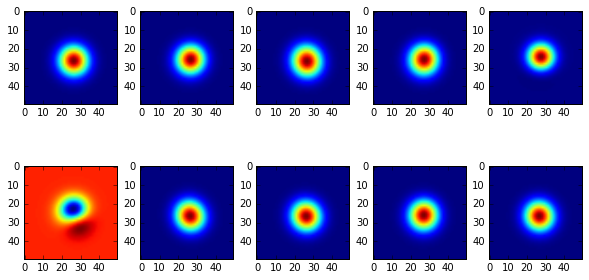

In [25]:
plt.figure()

print "\nweighted source image matrices for each scan:\n"

fig,axs = plt.subplots(2,K, figsize = (10,5))
fig.subplots_adjust(hspace = .25, wspace=.25)
axs = axs.ravel()

for n in range(N):
    axs[n].imshow(y_bar[n,:].reshape(lattice_shape, lattice_shape))
    
plt.show()

Finally calculating the log probability of the Generative model

In [26]:
# draw a sample from the approximate posterior
q = getSample(alpha, K, D, N)

print "\nlog probability of generative model:\n"
p_joint = evaluate_logDensity(y_bar, pi, q, K, D, N,V,lattice_shape)
print "\n", p_joint, "\n"


log probability of generative model:


[-95234.800552360379, -94561.661739703006, -276.7410681449868, -11.522583651492509, -384.8751608608992] 



In [27]:
def compute_scoresQ(alpha, q, ind_n, ind_k, ind_d):
    """
    Evaluates the scores (gradient of the log probability) for Q(M,W,L) our
    recognition model. We define functions to compute derivatives of univariate
    log Gaussian. These are then used in turn to compute gradients wrt all the
    variational parameters in alpha.
    ---------------------------------------------------------------------------
    Input:
            * alpha : Variational parameters of the recognition model
            * q     : Samples of M, W, L from the recognition model
            * ind   : indices for n, k, d
    Output:
            * grad  : Gradients of weights, centers and widths wrt the variational
                      parameters of the recognition model.
    """

    M, L, W = q[0], q[1], q[2]
    
    def z1(s,mu,var):
        # evaluates the score for the mean of a log univariate gaussian
        return (s-mu)/var
    
    def z2(s,mu,var):
        # evaluates the score for the variance of a log univariate gaussian
        return 0.5 - 0.5*(1./var)*(s-mu)**2
    
    # gradients of weights wrt mu and k
    grad_mu_w_nk     = z1(W[ind_n,ind_k], alpha['_mu_w_nk'],np.exp(1.0/alpha['_k_w_nk']))
    grad_k_w_nk      = z2(W[ind_n,ind_k], alpha['_mu_w_nk'],np.exp(1.0/alpha['_k_w_nk']))
    
    # gradients of centers wrt mu and k
    grad_mu_mu_kd    = z1(M[ind_k,ind_d], alpha['_mu_mu_k'], np.exp((1./alpha['_k_mu_k'])))
    grad_k_mu_kd     = z2(M[ind_k,ind_d], alpha['_mu_mu_k'], np.exp((1./alpha['_k_mu_k'])))
    
    # gradients of widths wrt mu and k
    grad_mu_lambda_k = z1(L[ind_k], alpha['_mu_lambda_k'], np.exp(1.0/alpha['_k_lambda_k'])) # <- cannot be negative!
    grad_k_lambda_k  = z2(L[ind_k], alpha['_mu_lambda_k'], np.exp(1.0/alpha['_k_lambda_k'])) # <- cannot be negative!
    
    grad = [grad_mu_w_nk, grad_k_w_nk, grad_mu_mu_kd, grad_k_mu_kd, grad_mu_lambda_k, grad_k_lambda_k]
    
    return grad

scores = compute_scoresQ(alpha, q, 5, 2, 1)
print "scores evaluated:\n\n", scores

scores evaluated:

[1.4197517747465107, -1.0559890694799066, -1.4662433347780366, -0.33246654113278229, 0.40248589637287446, -0.098494690020537345]


In [28]:
def compute_scoresQ_all(alpha, q, N, K, D):
    """
    Evaluates the scores (gradient of the log probability) for Q(M,W,L) our
    recognition model. We define functions to compute derivatives of univariate
    log Gaussian. These are then used in turn to compute gradients wrt all the
    variational parameters in alpha.
    ---------------------------------------------------------------------------
    Input:
            * alpha : Variational parameters of the recognition model
            * q     : Samples of M, W, L from the recognition model
            * ind   : indices for n, k, d
    Output:
            * grad  : Gradients of weights, centers and widths wrt the variational
                      parameters of the recognition model.
    """

    M, L, W = q[0], q[1], q[2]
    
    def z1(s,mu,var):
        # evaluates the score for the mean of a log univariate gaussian
        return (s-mu)/var
    
    def z2(s,mu,var):
        # evaluates the score for the variance of a log univariate gaussian
        return 0.5 - 0.5*(1./var)*(s-mu)**2
    
    # gradients of weights wrt mu and k
    grad_mu_w_nk = 0.
    grad_k_w_nk  = 0.
    
    for ind_n in range(N):
        for ind_k in range(K):
            
            grad_mu_w_nk     += z1(W[ind_n,ind_k], alpha['_mu_w_nk'],np.exp(1.0/alpha['_k_w_nk']))
            grad_k_w_nk      += z2(W[ind_n,ind_k], alpha['_mu_w_nk'],np.exp(1.0/alpha['_k_w_nk']))
    
    # gradients of centers wrt mu and k
    grad_mu_mu_kd = 0.
    grad_k_mu_kd  = 0.
    
    # gradients of widths wrt mu and k
    grad_mu_lambda_k = 0.
    grad_k_lambda_k  = 0.
    
    # gradients of centers wrt mu and k
    for ind_k in range(K):
        for ind_d in range(D):
            grad_mu_mu_kd    += z1(M[ind_k,ind_d], alpha['_mu_mu_k'], np.exp((1./alpha['_k_mu_k'])))
            grad_k_mu_kd     += z2(M[ind_k,ind_d], alpha['_mu_mu_k'], np.exp((1./alpha['_k_mu_k'])))
    

    
        grad_mu_lambda_k += z1(L[ind_k], alpha['_mu_lambda_k'], np.exp(1.0/alpha['_k_lambda_k'])) # <- cannot be negative!
        grad_k_lambda_k  += z2(L[ind_k], alpha['_mu_lambda_k'], np.exp(1.0/alpha['_k_lambda_k'])) # <- cannot be negative!
    
    grad = [grad_mu_w_nk, grad_k_w_nk, grad_mu_mu_kd, grad_k_mu_kd, grad_mu_lambda_k, grad_k_lambda_k]
    
    return grad


scores = compute_scoresQ_all(alpha, q, N, K, D)
print "ALL scores evaluated w/ new function:\n\n", scores

ALL scores evaluated w/ new function:

[4.1233241807923502, 4.4731615032177094, -3.3677864169595582, 1.709157260936105, 1.9830444873339974, -18.335036033852223]


In [29]:
def compute_mvn_scoresQ(alpha, q, K, D, N, V):
    """
    TODO: Extend the above to multivariate Gaussian score functions...
    """
    
    def z1(s, mu, sigma):
        ''' evaluates the score for the mean of a log mvn '''
        invcov = np.pinv(sigma)
        return np.dot(invcov,(s-mu))
    
    def z2(s, mu, sigma):
        ''' evaluates the score for the covariance of a log mvn '''
        invcov = np.pinv(sigma)
        return -0.5*(invcov - np.dot(invcov,np.dot(np.dot((s-mu),(s-mu)),invcov)))

    # gradients of weights wrt mu and k
    grad_mu_w_nk     = z1(W[ind_n,ind_k], alpha['_mu_w_nk'],np.exp(1.0/alpha['_k_w_nk']))
    grad_k_w_nk      = z2(W[ind_n,ind_k], alpha['_mu_w_nk'],np.exp(1.0/alpha['_k_w_nk']))
    # gradients of centers wrt mu and k
    grad_mu_mu_kd    = z1(M[ind_k,ind_d], alpha['_mu_mu_k'], np.exp((1./alpha['_k_mu_k'])))
    grad_k_mu_kd     = z2(M[ind_k,ind_d], alpha['_mu_mu_k'], np.exp((1./alpha['_k_mu_k'])))
    # gradients of widths wrt mu and k
    grad_mu_lambda_k = z1(L[ind_k], alpha['_mu_lambda_k'], np.exp(1.0/alpha['_k_lambda_k'])) # <- cannot be negative!
    grad_k_lambda_k  = z2(L[ind_k], alpha['_mu_lambda_k'], np.exp(1.0/alpha['_k_lambda_k'])) # <- cannot be negative!
    
    
    grad = [grad_mu_w_nk, grad_k_w_nk, grad_mu_mu_kd, grad_k_mu_kd, grad_mu_lambda_k, grad_k_lambda_k]
    
    return grad
    

def initializeParameters(Y, pi):
    
    N = Y.shape[0]
    V = Y.shape[1]
    alpha = {
        '_mu_w_nk'      : np.random.normal(0,1),            # mean of distribution over source k's weight in image n 
        '_k_w_nk'       : np.log(10),                       # log precision of distribution over source k's weight in image n
        '_mu_mu_k'      : pi['c'],                          # mean of distribution over source k's center
        '_k_mu_k'       : np.log(100./var_mu),              # diagional of log precision of distribution over source k's center
        '_mu_lambda_k'  : pi['mu_lambda'],                  # mean of distribution over source k's width
        '_k_lambda_k'   : 0.5                               # log precision of distribution over source k's width
        }
    
    return alpha
    
def VI_Optimizer(Y, K, pi, D, lattice_shape):
    """
    Variational Inference algorithm to learn parameters of our spatial factor analysis model.
    """
    # We define some parameters
    
    N = Y.shape[0]                              # number of scans, D is space lattice lives in
    V = Y.shape[1]                              # number of voxels (lattice_shape**D)
    
    t           = 0                             # number of iterations
    maxStepSize = 1                             # max step size
    eps         = 0.01                          # threshold
    alpha       = initializeParameters(Y,pi)    # recognition model parameters
    L           = len(alpha)                    # length of rec model params
    eta         = np.ones(L) #np.zeros(L)       # vector of zeros (ill defined here)
    _M          = 1                             # number of samples from q
    gamma       = 0.1                           # parameter that controls learning rate decrease
    
    G           = np.zeros([_M,L])              # used for control variates
    H           = np.zeros([_M,L])              # used for control variates
    
    delta       = np.zeros(L)
    
    converged   = False
    
    while not converged:
        
        print "iter:", t
        
        t  += 1
        
        a_0 = alpha
        
        q   = getSample(alpha, K, D, N) # faster to get 500 samples here or each time in loop
        
        for i, (key, value) in enumerate(alpha.items()):
            print "alpha_i:", key
            rho = gamma/eta[i] # learning rate <- eta[i] is zero here and so this is not properly defined here.
            
            for m in xrange(_M):

                ln_q = compute_lnQ(alpha, q, K, D, N)
                #print "ln q:", ln_q
                
                ln_p = evaluate_logDensity(Y, pi, q, K, D, N,V,lattice_shape)
                #print "ln p:", ln_p[0]
                
                the_scores = compute_scoresQ_all(alpha, q, N, K, D)
                #print "the scores:", the_scores
                
                import pdb
                #pdb.set_trace()
                
                lnP_lnQ = (ln_p[0] - ln_q)
                
                G[m,:]  = np.dot(the_scores, lnP_lnQ)
                
                H[m,:]  = the_scores
            
            # Control Variate
            beta = np.cov(G,H)/np.var(H)
            
            # Using trick to reduce variance
            grad_cost = G[m] #- beta*H[m]
            print "the cost:", grad_cost
            
            delta[i] = max(min(rho*grad_cost[i],maxStepSize),-maxStepSize)
            
            alpha[key] = a_0[key] + delta[i] # alpha a dict, must access differently
            
            eta[i]  += grad_cost[i]**2
            
            #print "delta:", key, value, delta[i]
        if max(delta) < eps:
            
            converged = True
    
    
    return alpha


print "Testing the VI optimizer"

myalpha = VI_Optimizer(y_bar, K, pi, D, lattice_shape)

Testing the VI optimizer
iter: 0
alpha_i: _k_mu_k
the cost: [ -438896.87220402   554551.15171428  -360813.3068749   -383430.55852729
    49129.95128021  2671024.34602392]
alpha_i: _mu_mu_k
the cost: [ -438896.28674805   554550.41198405  -342516.29216561  -395236.54699285
    49129.88574449  2671020.78307497]
alpha_i: _mu_lambda_k
the cost: [ -438884.35772455   554535.33952821  1168251.51881667    17646.46342925
    49128.55041407  2670948.18581072]
alpha_i: _k_lambda_k
the cost: [ -438881.73344875   554532.02372612  1168244.53334513    17646.35791355
   132526.88430171  2761759.78555585]
alpha_i: _mu_w_nk
the cost: [  -438645.81113356    554233.9332181    1167616.53966482
     17636.87205598    502492.7242657   11331885.61709155]
alpha_i: _k_w_nk
the cost: [  3550344.76853379   2110049.06726353   1167496.80223145
     17635.06341957    502441.1943438   11330723.54816486]
iter: 1
alpha_i: _k_mu_k
the cost: [-633913.83027094  815760.1941943   359458.68901611 -116132.93594012
  -91168.255